# Use case 3: retrieving footprints

## Notebook setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from s1etad import Sentinel1Etad

## Open the dataset

In [5]:
filename = (
    "data/"
    "S1B_IW_ETA__AXDV_20200124T221416_20200124T221444_019964_025C43_0A63.SAFE"
)

In [6]:
eta = Sentinel1Etad(filename)

In [7]:
eta

Sentinel1Etad("data/S1B_IW_ETA__AXDV_20200124T221416_20200124T221444_019964_025C43_0A63.SAFE")  # 0x79eea1df9cd0
Number of Sentinel-1 slices: 1
Sentinel-1 products list:
  S1B_IW_SLC__1ADV_20200124T221416_20200124T221444_019964_025C43_95FB.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Azimuth time:
  min: 2020-01-24 22:14:16.480938
  max: 2020-01-24 22:14:44.428152
Range time:
  min: 0.005328684957372668
  max: 0.006383362874313361
Grid sampling:
  x: 8.131672451354599e-07
  y: 0.02932551319648094
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

## Helpers

In [8]:
import cartopy.crs as ccrs
from matplotlib import patches as mpatches
from shapely.geometry import MultiPolygon


def tile_extent(poly, margin=2):
    bounding_box = list(poly.bounds)
    bounding_box[1:3] = bounding_box[2:0:-1]
    return np.asarray(bounding_box) + [-margin, margin, -margin, margin]

## Select bursts

In [9]:
import dateutil

first_time = dateutil.parser.parse("2020-01-24 22:14:21.994134480")
selection = eta.query_burst(first_time=first_time)

## Get footprints of the selected bursts

In [10]:
polys = eta.get_footprint(selection=selection)

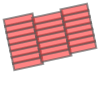

In [11]:
polys

## Plot footprints

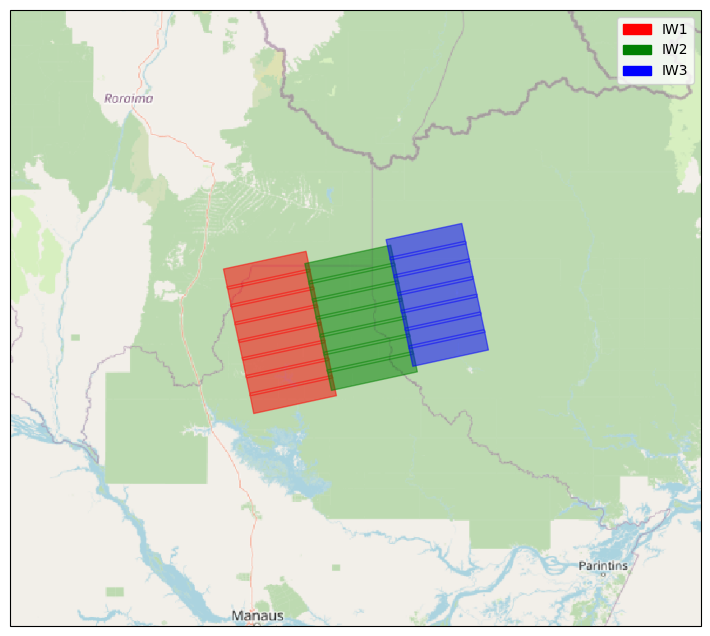

In [12]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(tile_extent(MultiPolygon(polys)))

# Put a background image on for nice sea rendering.
OFFLINE = False
if OFFLINE:
    import cartopy.feature as cfeature

    ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
else:
    import cartopy.io.img_tiles as cimgt

    # stamen_terrain = cimgt.Stamen("terrain-background")  # need cartopy >= 0.17
    img = cimgt.OSM()
    ax.add_image(img, 7)  # up to 10
    ax.coastlines()

# plot footprints of all selected burst
# ax.add_geometries(polys, crs=ccrs.PlateCarree(), alpha=0.8)

# get the footprints of each swath and plot them with different colors
items = []
for swath, color in zip(eta, ["red", "green", "blue"]):
    polys = swath.get_footprint(selection=selection)
    item = ax.add_geometries(
        polys, crs=ccrs.PlateCarree(), alpha=0.5, color=color
    )
    items.append(item)

handles = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(["red", "green", "blue"], eta.swath_list)
]
plt.legend(handles=handles)